# L96 + PF


In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.pf import ParticleFilter as PF

data_dir = "../data"

In [121]:
# Lorenz96の設定
J = 10
F = 8

In [125]:
# generate data
# dt: time step size
dt = 0.1
print("dt:", dt)

# N: number of time steps, 2 years : 20*360*2 steps
N = 1000
N0 = N//2
print("N:", N)

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[J//2] *= 1.001 # perturb

# use my modules
scheme = rk4
p = (F, )

try:
    # raise FileNotFoundError  # force to generate data
    x_true = np.load(f"{data_dir}/x_true_l96_full.npy")
    print("x_true loaded:", x_true.shape)
except:
    result = np.zeros((N0+N,len(x0)))
    x = x0
    result[0] = x[:]

    for n in range(1, N0+N):
        t = n*dt
        x = scheme(lorenz96, t, x, p, dt)
        result[n] = x[:]


    x_true = result[N0:] # spin up 1 year and save per 6 hours
    print("x_true.shape:", x_true.shape)
    np.save(f"{data_dir}/x_true_l96_full", x_true)

dt: 0.1
N: 1000
x_true.shape: (1000, 10)


In [126]:
# observation steps
obs_per = 1
print("obs_per", obs_per, "steps")

# assimilation interval
Dt = dt * obs_per
print("assimilation interval: ", Dt)


# time array
t = np.arange(N//obs_per)*dt


# Model function for time evolution
def M(x, Dt):
    for i in range(int(Dt/dt)):
        x = rk4(lorenz96, 0, x, p, dt)
    return x

# Observation operator
# H_diag = np.ones(J) # full

H_diag = np.ones(J)
# H_diag[2::3] = 0 # partial observations


H = np.diag(H_diag)
H = H[H_diag != 0] # remove zero rows
Ny = np.linalg.matrix_rank(H)
print("H.shape:", H.shape)
print("diag of H:", H_diag)
# print("rank(H):", Ny)


# Observation error covariance
r = 1
R = r**2*np.eye(J)
R = H @R@H.T # project to obs space
print("obs noise std:", r)



# load true states
# Nt = (N0+N)//5//6
Nt = N
x_true = np.load(f"{data_dir}/x_true_l96_full.npy")[:Nt:obs_per]

obs_per 1 steps
assimilation interval:  0.1
H.shape: (10, 10)
diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
obs noise std: 1


In [141]:
# generate observations
end = 500
y = (H@x_true[:end].T).T
y += np.random.multivariate_normal(mean=np.zeros_like(y[0]), cov=R, size=len(y))

h = lambda x: H@x # observation function

m = 1000
X0 = np.random.normal(0, 1, (m, J)) # initial state
pf = PF(M, h, R, N_thr=0.95, add_inflation=0.2)
pf.initialize(X0)
for y_obs in tqdm(y):
    pf.forecast(dt)
    pf.update(y_obs)

x_assim = pf.x

100%|██████████| 500/500 [01:07<00:00,  7.42it/s]


Text(0.5, 0, 'Observation step')

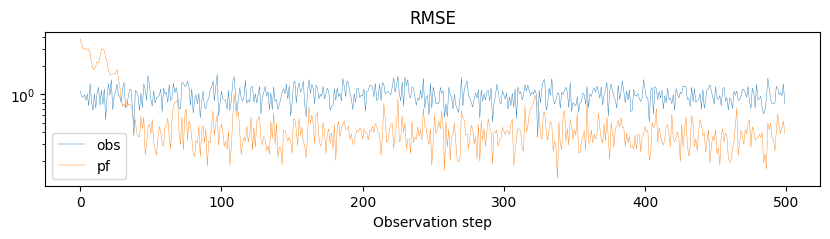

In [142]:
# plot rmse
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true[:end]@H.T, y, loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true[:end], x_assim, loss_rms, ax=ax, label='pf', lw=0.3)
# plt.plot(np.sqrt(pf.trP), lw=0.3, label='trP')
ax.legend()
# ax.set_ylim([-1, 1])
ax.set_title("RMSE")
ax.set_yscale("log")
ax.set_xlabel("Observation step")